In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns

from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

from collections import Counter
from scipy.sparse import hstack

from sklearn.svm import SVC

from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math


warnings.filterwarnings("ignore")





import nltk
nltk.download('stopwords')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported f

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
data = pd.read_csv('training_variants')

In [ ]:
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [ ]:
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


**Data Pre-processing**

In [ ]:
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [ ]:
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 26.730524999999997 seconds


In [ ]:
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [ ]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder() 
  
result['Gene']= le.fit_transform(result['Gene']) 
result['Variation']= le.fit_transform(result['Variation'])

In [ ]:
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,85,2629,1,cyclin dependent kinases cdks regulate variety...
1,1,39,2856,2,abstract background non small cell lung cancer...
2,2,39,1897,2,abstract background non small cell lung cancer...
3,3,39,1667,3,recent evidence demonstrated acquired uniparen...
4,4,39,1447,4,oncogenic mutations monomeric casitas b lineag...


In [ ]:
result['Text-final'] = result['TEXT']+ " " +result['Gene'].astype(str)+ " "+result['Variation'].astype(str)

In [ ]:
result['Text-final'][0]

'cyclin dependent kinases cdks regulate variety fundamental cellular processes cdk10 stands one last orphan cdks activating cyclin identified kinase activity revealed previous work shown cdk10 silencing increases ets2 v ets erythroblastosis virus e26 oncogene homolog 2 driven activation mapk pathway confers tamoxifen resistance breast cancer cells precise mechanisms cdk10 modulates ets2 activity generally functions cdk10 remain elusive demonstrate cdk10 cyclin dependent kinase identifying cyclin activating cyclin cyclin orphan cyclin product fam58a whose mutations cause star syndrome human developmental anomaly whose features include toe syndactyly telecanthus anogenital renal malformations show star syndrome associated cyclin mutants unable interact cdk10 cyclin silencing phenocopies cdk10 silencing increasing c raf conferring tamoxifen resistance breast cancer cells cdk10 cyclin phosphorylates ets2 vitro cells positively controls ets2 degradation proteasome ets2 protein levels increa

In [ ]:
cleaned_text=result['Text-final'].values

In [ ]:
all_words=[]
for sentence in cleaned_text:
    words = sentence.split()
    all_words += words

In [ ]:
counts = Counter(all_words)

In [ ]:
vocabulary = len(counts.most_common()) + 1

In [ ]:
top_words=counts.most_common(20000)
print(len(top_words))

20000


In [ ]:
word_index_lookup = dict()
i = 1
for word,frequency in top_words:
    word_index_lookup[word] = i
    i += 1

In [ ]:
print("Top 25 words with their frequencies:")
print(counts.most_common(50))

Top 25 words with their frequencies:
[('mutations', 238168), ('1', 215000), ('cells', 185832), ('2', 154200), ('3', 135269), ('cell', 126657), ('mutation', 105671), ('5', 104867), ('et', 104597), ('fig', 104569), ('al', 104412), ('0', 102305), ('c', 101888), ('cancer', 99162), ('figure', 98445), ('patients', 86447), ('4', 84963), ('protein', 84720), ('expression', 77652), ('activity', 76677), ('mutant', 73387), ('type', 72468), ('tumor', 69514), ('also', 66358), ('variants', 66177), ('kinase', 65798), ('domain', 65388), ('using', 63497), ('binding', 62832), ('gene', 61393), ('brca1', 61344), ('data', 60266), ('p', 59880), ('analysis', 58962), ('b', 57531), ('wild', 56951), ('dna', 56315), ('10', 56197), ('egfr', 54761), ('6', 54140), ('tumors', 53256), ('mutants', 53190), ('two', 52285), ('table', 51861), ('activation', 50169), ('may', 49437), ('7', 47985), ('results', 45962), ('shown', 43895), ('8', 43626)]


In [ ]:
def ranking(row):  
    buffer = []
    for word in row['Text-final'].split():
        if word in word_index_lookup:
            buffer.append(word_index_lookup[word]) 
        else:
            buffer.append(0)            
    return buffer


result['CleanedText_Index'] = result.apply(lambda row: ranking(row),axis=1)
result.head(5)

,ID,Gene,Variation,Class,TEXT,Text-final,CleanedText_Index
0,0,85,2629,1,cyclin dependent kinases cdks regulate variety...,cyclin dependent kinases cdks regulate variety...,"[271, 187, 383, 4380, 1169, 1292, 4297, 305, 1..."
1,1,39,2856,2,abstract background non small cell lung cancer...,abstract background non small cell lung cancer...,"[2925, 1378, 209, 191, 6, 142, 14, 328, 2307, ..."
2,2,39,1897,2,abstract background non small cell lung cancer...,abstract background non small cell lung cancer...,"[2925, 1378, 209, 191, 6, 142, 14, 328, 2307, ..."
3,3,39,1667,3,recent evidence demonstrated acquired uniparen...,recent evidence demonstrated acquired uniparen...,"[475, 275, 364, 753, 15273, 10998, 7564, 395, ..."
4,4,39,1447,4,oncogenic mutations monomeric casitas b lineag...,oncogenic mutations monomeric casitas b lineag...,"[199, 1, 5708, 0, 35, 1959, 947, 552, 30, 62, ..."


In [ ]:

x_train, x_test, y_train, y_test = train_test_split(result['CleanedText_Index'].values,result['Class'], test_size=0.3,shuffle=False,random_state=0)
                                                    
                                                           
                                                            
                                                            

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
# fix random seed for reproducibility
np.random.seed(7)

In [ ]:
from keras.utils import np_utils
y_train=np_utils.to_categorical(y_train)
y_test=np_utils.to_categorical(y_test)

**Padding on Data**

In [ ]:
max_review_length = 375
x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print("Total number words present in first review after padding:\n",len(x_train[1]))
print()
print("List of word indexes present in first review padding:\n", x_train[1])
print()

Total number words present in first review after padding:
 375

List of word indexes present in first review padding:
 [   62   184    96   104  1490   215    39     1   726    47   142    23
   104   186    13   552     1   226   254   186  1309    13   552   292
  1100  2359    13   552   316   162   797   142    14   577  1100   632
  3892   599   719  1251   381   491   350    56     7   215    39   868
   918   485  1848  2543    46  1017   148  2308  1058  1100    13   552
    48  4149     0  1848  1059   710 12369  2645    77   200   895   599
   810   803   277   236   943   726    13   552   123   127    26    20
  2765   895    23   273   381   491   350    13   552  1100   141    24
   677   127    19    13   552   283  8038   122   283     0   141   323
  7205  5321   270    13   552    70   162   588 18616   386   632   327
    79  5243  1089    49  5003  7780   142   146   807   102  1341   532
    64     1  2645    39   215   404   728  3394    16   232   215     7
    6

In [ ]:
x_test.shape

(997, 375)

In [ ]:
y_test.shape

(997, 10)

**LSTM Model**

In [ ]:
embedding_vecor_length = 100
model = Sequential()
model.add(Embedding(vocabulary, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100,dropout=0.2))
model.add(Dense(10, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 375, 100)          3737600   
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1010      
Total params: 3,819,010
Trainable params: 3,819,010
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=10,validation_data=(x_test, y_test))

Epoch 1/10
233/233 [==============================] - 67s 289ms/step - loss: 1.7776 - accuracy: 0.2883 - val_loss: 2.0321 - val_accuracy: 0.2839
Epoch 2/10
233/233 [==============================] - 67s 287ms/step - loss: 1.4078 - accuracy: 0.4613 - val_loss: 2.1867 - val_accuracy: 0.1896
Epoch 3/10
233/233 [==============================] - 68s 290ms/step - loss: 1.0343 - accuracy: 0.6248 - val_loss: 2.1347 - val_accuracy: 0.2197
Epoch 4/10
233/233 [==============================] - 67s 287ms/step - loss: 0.8688 - accuracy: 0.7027 - val_loss: 2.1389 - val_accuracy: 0.2106
Epoch 5/10
233/233 [==============================] - 67s 288ms/step - loss: 0.7429 - accuracy: 0.7470 - val_loss: 2.7473 - val_accuracy: 0.1836
Epoch 6/10
233/233 [==============================] - 67s 287ms/step - loss: 0.6841 - accuracy: 0.7651 - val_loss: 2.7031 - val_accuracy: 0.1936
Epoch 7/10
233/233 [==============================] - 68s 290ms/step - loss: 0.6210 - accuracy: 0.7788 - val_loss: 2.2004 - val_ac

In [ ]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

Test loss: 3.2139739990234375
Test accuracy: 0.19859579205513


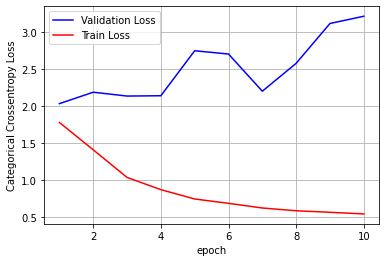

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])
epochs = 10

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

**Bi-Directional RNN**

In [ ]:
EMBEDDING_DIM = 10

model = Sequential()
model.add(Embedding(vocabulary, EMBEDDING_DIM, input_length=max_review_length))
model.add(Bidirectional(GRU(100)))
model.add(Dense(56, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 375, 10)           1563320   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200)               67200     
_________________________________________________________________
dense_10 (Dense)             (None, 56)                11256     
_________________________________________________________________
dropout_5 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                570       
Total params: 1,642,346
Trainable params: 1,642,346
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, epochs=20, batch_size=20,validation_data=(x_test, y_test))

Epoch 1/20
117/117 [==============================] - 38s 325ms/step - loss: 0.4243 - accuracy: 0.8188 - val_loss: 3.4534 - val_accuracy: 0.2217
Epoch 2/20
117/117 [==============================] - 38s 325ms/step - loss: 0.4221 - accuracy: 0.8206 - val_loss: 3.2158 - val_accuracy: 0.2227
Epoch 3/20
117/117 [==============================] - 38s 324ms/step - loss: 0.4225 - accuracy: 0.8180 - val_loss: 3.4436 - val_accuracy: 0.2287
Epoch 4/20
117/117 [==============================] - 38s 324ms/step - loss: 0.4136 - accuracy: 0.8176 - val_loss: 3.4454 - val_accuracy: 0.2106
Epoch 5/20
117/117 [==============================] - 38s 324ms/step - loss: 0.4147 - accuracy: 0.8236 - val_loss: 3.4230 - val_accuracy: 0.2156
Epoch 6/20
117/117 [==============================] - 38s 324ms/step - loss: 0.4015 - accuracy: 0.8249 - val_loss: 3.4799 - val_accuracy: 0.1936
Epoch 7/20
117/117 [==============================] - 38s 324ms/step - loss: 0.4141 - accuracy: 0.8279 - val_loss: 3.3907 - val_ac

Test loss: 4.212344169616699
Test accuracy: 0.20060180127620697


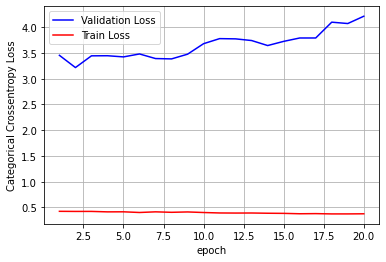

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])
epochs = 20

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)